# Final Project: Weather Prediction

In [1]:
#Import necessary packages
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Data at a First-Look

We must first import the data. The set contains useful information,features, and their range as described below:

- Pregnancies: ∈ {0,17}
The number of times the patient has been pregnant

- Glucose: ∈ {0,199}
Plasma glucose concentration in an oral glucose tolerance test

- BloodPressure ∈ {0,122}
Diastolic blood pressure in mm Hg

- SkinThickness ∈ {0,99}
Triceps skin fold thickness in mm

- Insulin ∈ {0,846}
2-hour serum insulin levels in mu U / ml

- BMI ∈ {0,67.1}
Body mass index in (weight in kg / (height in m)^2)

- DiabetesPedigreeFunction ∈ {0.078, 2.420000}

- Age ∈ {21,81}
Age of the patient in years

- Outcome ∈ [0, 1]
1 if the patient has diabetes and 0 otherwise

It is also helpful to see the mean, median, and other statistics of the data.

In [2]:
df = pd.read_csv('diabetes.csv')

In [3]:
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [4]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


# Data Visualization 

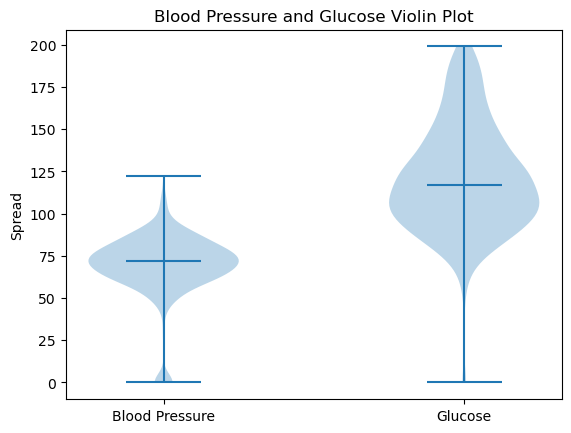

In [7]:
plt.violinplot([df['BloodPressure'],df['Glucose']],showextrema=True,showmedians=True)

plt.title('Blood Pressure and Glucose Violin Plot')
plt.xticks([1,2],['Blood Pressure','Glucose'])
plt.ylabel('Spread')

plt.show()

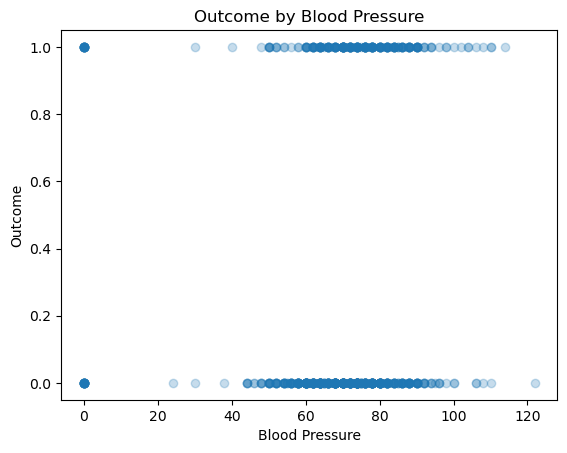

In [8]:
plt.scatter(df['BloodPressure'],df['Outcome'], alpha = 0.25) 
plt.title('Outcome by Blood Pressure')
plt.xlabel('Blood Pressure')
plt.ylabel('Outcome')

plt.show()

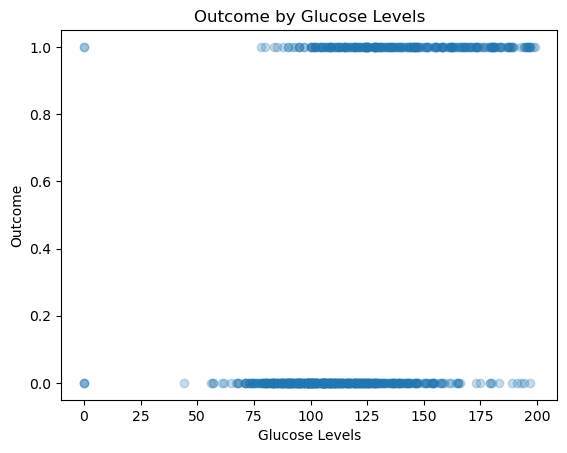

In [9]:
plt.scatter(df['Glucose'],df['Outcome'], alpha = 0.25) 
plt.title('Outcome by Glucose Levels')
plt.xlabel('Glucose Levels')
plt.ylabel('Outcome')

plt.show()

In [5]:
from sklearn.neighbors import KNeighborsClassifier


X = df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']]
Y = df['Outcome']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

KNN = KNeighborsClassifier()
KNN.fit(X_train, Y_train)


predictions = KNN.predict(X_test)

print("Accuracy: ", accuracy_score(Y_test, predictions))

Accuracy:  0.7402597402597403


In [6]:
# This is the function we use to create the decision tree model
from sklearn import tree


model = tree.DecisionTreeClassifier(max_depth = 5)

# TODO: train the model
# FILL IN HERE
model.fit(X_train, Y_train)

# TODO: Calculate the training and testing accuracy
dtree_pred_train = model.predict(X_train)
dtree_pred_test = model.predict(X_test)
print("Train Accuracy: ", accuracy_score(dtree_pred_train, Y_train))
print("Test Accuracy: ", accuracy_score(dtree_pred_test, Y_test))

Train Accuracy:  0.8420195439739414
Test Accuracy:  0.7402597402597403
